<a href="https://colab.research.google.com/github/Sanjit1806/RAG_CohereLLM/blob/main/CohereLLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install PyPDF2
!pip install annoy
!pip install cohere

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 15.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp310-cp310-linux_x86_64.whl size=552449 sha256=533d2acb9ad045aa9083c90feff5838eaa7bd66e67bb3466889eabce82928fd2
  Stored in directory: /root/.cache/pip/wheels/64/8a/da/f714bcf46c5efdcfcac0559e63370c21abe961c48e3992465a
Successfully built annoy
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.2/249.2 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.1/139.1 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [6]:
import cohere
import numpy as np
from annoy import AnnoyIndex
import PyPDF2
import warnings

warnings.filterwarnings('ignore')

# Initialize Cohere client
co = cohere.Client('Enter Cohere API Key')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [17]:
# pdf to text
def extract_text_from_pdf(pdf_path):
    with open(pdf_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        text = ""

        for page in range(len(reader.pages)):
            page_obj = reader.pages[page]
            text += page_obj.extract_text()
    return text

pdf_path = "book"
extracted_text = extract_text_from_pdf(pdf_path)

In [10]:
# clean up
def prepare_text(text):
    texts = text.split('\n \n')
    # print(texts)
    texts = np.array([t.strip(' \n') for t in texts if t])
    return texts

texts = prepare_text(extracted_text)
# print(texts)
texts.shape

(58,)

In [11]:
# Embedding
def embed_text(texts):
    response = co.embed(texts=texts.tolist()).embeddings
    embeds = np.array(response)
    return embeds

embeds = embed_text(texts)
embeds.shape

(58, 4096)

In [12]:
def build_annoy_index(embeds):
    search_index = AnnoyIndex(embeds.shape[1], 'angular')
    for i in range(len(embeds)):
        search_index.add_item(i, embeds[i])
    search_index.build(10)
    return search_index

search_index = build_annoy_index(embeds)
search_index

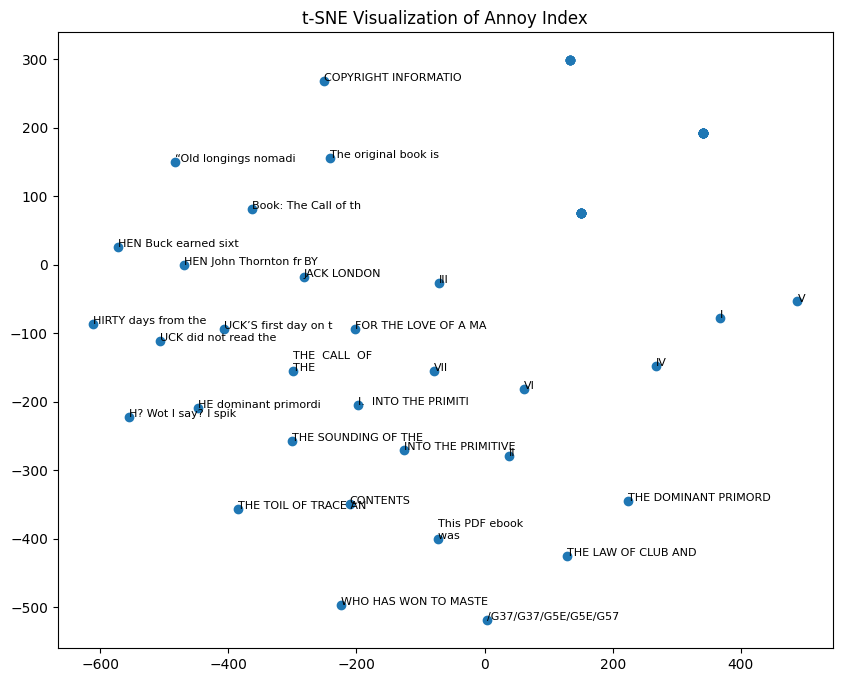

In [16]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Visualizes the Annoy index using t-SNE.
def visualize_annoy_index(search_index, embeds, texts, n_components=2):

  # Reduce dimensionality of embeddings using t-SNE
  tsne = TSNE(n_components=n_components, random_state=0)
  reduced_embeds = tsne.fit_transform(embeds)

  # Plot the reduced embeddings
  plt.figure(figsize=(10, 8))
  plt.scatter(reduced_embeds[:, 0], reduced_embeds[:, 1])

  # Add text labels for each point
  for i, txt in enumerate(texts):
      plt.annotate(txt[:20], (reduced_embeds[i, 0], reduced_embeds[i, 1]), fontsize=8)

  plt.title('t-SNE Visualization of Annoy Index')
  plt.show()

# Assuming you have your search_index, embeds, and texts defined
visualize_annoy_index(search_index, embeds, texts)


In [14]:
# Search relevant text
def search_text(query, search_index, texts):
    query_embed = co.embed(texts=[query]).embeddings

    similar_item_ids = search_index.get_nns_by_vector(query_embed[0], 10, include_distances=True)
    search_results = texts[similar_item_ids[0]]
    return search_results

# LLM model
def ask_llm(question, search_index, texts, num_generations=1):
    results = search_text(question, search_index, texts)
    context = results

    prompt = f"""
    Answer the question based only on the following context:

    {context}

    ---

    Answer the question based on the above context: {question}

    If the text doesn't contain the answer,
    reply that the answer is not available.
    """
    # If the answer is not up to the mark, respond with "Answer not available."

    # Cohere LLM
    prediction = co.generate(
        prompt=prompt,
        max_tokens=70,
        model="command-nightly",
        temperature=0.5,
        num_generations=num_generations
    )

    return prediction.generations

In [15]:
question = input("Enter the question: ")

results = ask_llm(question, search_index, texts)

print(f"Answer: {results[0].text.strip()}")

Enter the question: how does the book end
Answer: The book ends with Buck returning to the camp to find Dave, a dog who had been taken out of the traces due to injury, lying gasping in the snow and yearning toward his mates. Dave's driver shoots him to end his suffering, and the sleds continue on their way.
